In [51]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Build Agent with OpenAI Gym

In [52]:
env = gym.make('CartPole-v0')

print(env.metadata)
print(env.observation_space)
print(env.action_space)

{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
Box(4,)
Discrete(2)


In [53]:
# trying out the gym
game_state = env.reset()
done = False

while not done: 
    env.render()
    sampled_action = env.action_space.sample()
    game_state, reward, done, info = env.step(sampled_action)

    
env.close()

## 2. The Model

In [54]:
tf.reset_default_graph()
state = tf.placeholder(tf.float32, [1,4])

# Hidden Layer representing policy network
with tf.variable_scope("hidden_layer", reuse=tf.AUTO_REUSE):
    initializer = tf.random_normal_initializer(stddev=0.002)
    weights = tf.get_variable("weights", [4, 8], tf.float32, initializer)
    biases = tf.get_variable("biases", 8, tf.float32, tf.zeros_initializer())
# forward prop
    drive = tf.matmul(state, weights) + biases
    hidden_out = tf.tanh(drive)

# Output Layer -- outputs probability of action given state
with tf.variable_scope("output_layer", reuse=tf.AUTO_REUSE):
    weights = tf.get_variable("weights", [8, 1], tf.float32, initializer)
    biases = tf.get_variable("biases", 1, tf.float32, tf.zeros_initializer)
    drive = tf.matmul(hidden_out, weights) + biases
    output = tf.sigmoid(drive)


In [55]:
# Action Selection
log_probabilities = tf.log(tf.concat([output, 1 - output], 1))
action = tf.multinomial(log_probabilities, num_samples = 1)[0][0]

action_probability= log_probabilities[:, tf.to_int32(action)] 

## 3. Gradients

In [56]:
learn_rate = 0.02
optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate)
gradients_variables = optimizer.compute_gradients(action_probability)

gradients = [gradvar[0] * -1 for gradvar in gradients_variables]

# apply the gradients
gradient_placeholders = [tf.placeholder(tf.float32, gradient.shape) for gradient in gradients]
training_step = optimizer.apply_gradients(zip(gradient_placeholders, tf.trainable_variables()))


## 4. Training

In [57]:
# helper func
discount_factor = 0.99
def discount_rewards(rewards, discount_factor):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    for i, reward in enumerate(reversed(rewards)):
        discounted_rewards[-(i+1)] = discounted_rewards[-i] * discount_factor + reward
    normalized_rewards = ((discounted_rewards - np.mean(discounted_rewards)) / np.std(discounted_rewards))
    return normalized_rewards


Training
Episode 1...
Episode 3...
Episode 5...
Episode 7...
Episode 9...
Episode 11...
Episode 13...
Episode 15...
Episode 17...
Episode 19...
Episode 21...
Episode 23...
Episode 25...
Episode 27...
Episode 29...
Episode 31...
Episode 33...
Episode 35...
Episode 37...
Episode 39...


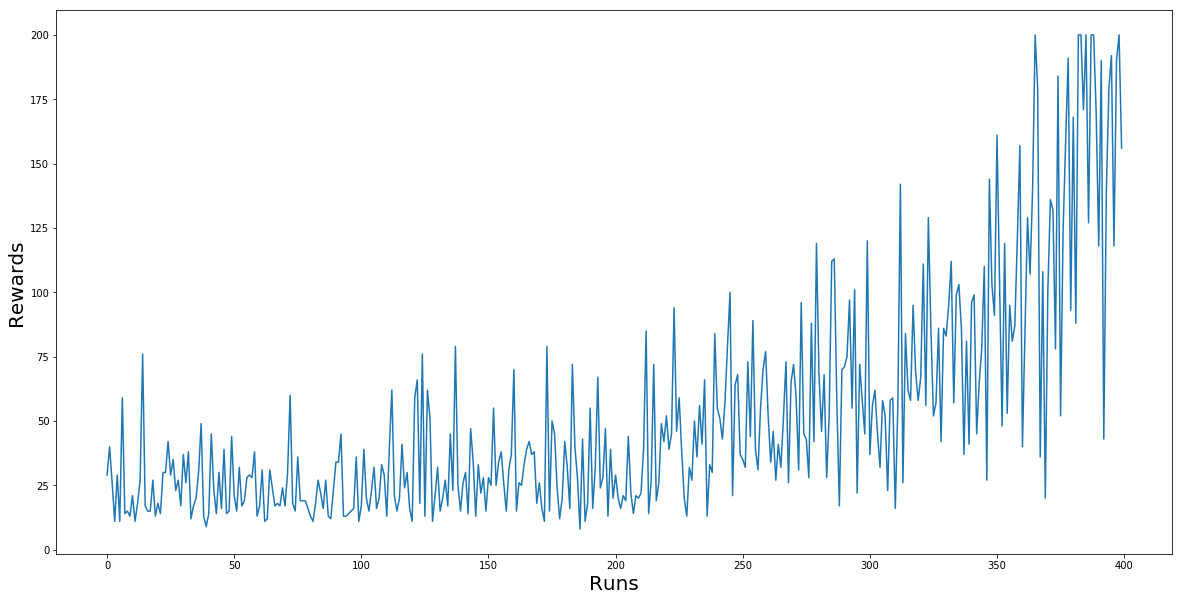

In [58]:
env = gym.make('CartPole-v0')
episodes = 40
runs = 10

r = [] 

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    global_step = 0
   
    print('Training') 
    for i in range(episodes):
        episode_gradients = []
        if i%2 == 0:
            print('Episode {}...'.format(i+1))
            
        # runs to simulate mini-batching
        for j in range(runs):
            run_gradients =[]
            run_rewards = []
            
            game_state = env.reset()

            done = False
            
            while not done: 
                env.render()
                
                game_state = np.reshape(game_state,newshape=(1,4))
                sampled_action, rgradient = sess.run((action,gradients),# get action we took, & 4 gradients
                                                     feed_dict={state: game_state})
                
                game_state, reward, done, _info = env.step(sampled_action)
                
                
                
                run_gradients.append(rgradient) 
                run_rewards.append(reward)
#                 if done:
#                     print("Rewards:", sum(run_rewards))

            # for plotting        
            gained_reward = len(run_rewards) 
            r.append(gained_reward)
            
            dis_rewards = discount_rewards(run_rewards, discount_factor)
            dis_rewards = np.expand_dims(dis_rewards, axis=1)
            

            gradient_rewards = [dis_rewards[i] * run_gradients[i] for i in range(len(dis_rewards))]
          
    
            
            gradient_rewards = np.sum(np.array(gradient_rewards), axis=0)
            
            episode_gradients.append(gradient_rewards)
            
        total_gradients = np.sum(np.array(episode_gradients), axis=0)
        
        sess.run(training_step, feed_dict={placeholder: total_gradients[i]
                                          for i, placeholder in enumerate(gradient_placeholders)})
        
        global_step+=1
        
    
    plt.figure(figsize=(20,10))
    xplt = range(400)
    yplt = np.array(r)
    plt.plot(xplt,yplt)
    plt.ylabel('Rewards', fontsize=20)
    plt.xlabel('Runs', fontsize=20)

        
    env.close()                
                
            

            